<a href="https://colab.research.google.com/github/andyrids/mipo_trajectory/blob/main/MiPo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import haversine
    import folium
except ImportError:
    %pip install haversine mapclassify folium -q
    import haversine
    import folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [164]:
import io
import multiprocessing
import pathlib
import zipfile
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import requests
from IPython.display import HTML
from numpy import float64
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame, Series, concat, read_csv, to_datetime, to_timedelta
from scipy.stats import median_abs_deviation
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
# from sklearn.metrics import silhouette_score

In [4]:
def calculate_earth_radius(latitude_values: ArrayLike) -> NDArray[float64]:
    """"""
    EQUATORIAL_RADIUS = 6_378_137
    POLAR_RADIUS = 6_356_752

    latitude_rad = np.radians(latitude_values)
    numerator = (
        (EQUATORIAL_RADIUS**2 * np.cos(latitude_rad))**2 +
        (POLAR_RADIUS**2 * np.sin(latitude_rad))**2
    )
    denominator = (
        (EQUATORIAL_RADIUS * np.cos(latitude_rad))**2 +
        (POLAR_RADIUS * np.sin(latitude_rad))**2
    )
    earth_radius = np.sqrt(numerator / denominator)
    return earth_radius


def latlong_to_cartesian_xyz(latitude_values: ArrayLike, longitude_values: ArrayLike) -> Tuple[NDArray[float64], NDArray[float64], NDArray[float64]]:
    """"""
    latitude_rad = np.radians(latitude_values)
    longitude_rad = np.radians(longitude_values)
    earth_radius = calculate_earth_radius(latitude_values)

    x = earth_radius * np.cos(latitude_rad) * np.cos(longitude_rad)
    y = earth_radius * np.cos(latitude_rad) * np.sin(longitude_rad)
    z = earth_radius * np.sin(latitude_rad)
    return x, y, z


def calculate_mzx(data: ArrayLike, c_mad: float = 1.4826) -> NDArray[float64]:
    """"""
    data = np.where(np.isinf(data), np.nan, data)
    if np.isnan(data).all():
        return data
    median_ad = median_abs_deviation(data, nan_policy="omit")
    constant = c_mad

    if not median_ad or np.isnan(median_ad):
        mean_ad = np.nanmean(np.abs(data - np.nanmean(data)))
        if not mean_ad or np.isnan(mean_ad):
            return np.full_like(data, np.nan)

        modified_zscore = constant * (data - np.nanmedian(data)) / mean_ad
    else:
        modified_zscore = constant * (data - np.nanmedian(data)) / median_ad
    return np.abs(modified_zscore)

In [5]:
def read_csv_files(path: pathlib.Path) -> DataFrame:
    data = read_csv(path, sep=";")
    return data.assign(uid=path.stem)


def process_file(path: pathlib.Path) -> DataFrame | None:
    try:
        return read_csv_files(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool:
    data_path = pathlib.Path("data/data")
    if not data_path.exists():
        r = requests.get("https://figshare.com/ndownloader/files/16442771")
        zf = zipfile.ZipFile(io.BytesIO(r.content))
        zf.extractall(path="data")

    paths = tuple(data_path.glob("*.txt"))
    results = pool.map(process_file, paths[:100])

dataframes = filter(lambda x: isinstance(x, DataFrame), results)

data = (
    concat(dataframes)
    .assign(t=lambda x: to_timedelta(x["t"], unit="s"))
    .assign(datetime=lambda x: to_datetime("now") + x["t"])
    .filter(("uid", "datetime", "x", "y", ), axis="columns")
    .rename(columns={"x": "longitude", "y": "latitude"})
    .astype({"uid": "string"})
    .sort_values(["uid", "datetime"])
    .reset_index(drop=True)
)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40074 entries, 0 to 40073
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   uid        40074 non-null  string        
 1   datetime   40074 non-null  datetime64[ns]
 2   longitude  40074 non-null  float64       
 3   latitude   40074 non-null  float64       
dtypes: datetime64[ns](1), float64(2), string(1)
memory usage: 1.2 MB


In [7]:
# kmeans = KMeans(n_clusters=2, random_state=0).fit(X[[0,-1]])
# res = kmeans.cluster_centers_

In [129]:
def calculate_theta_angle(
        source_point: NDArray[float64],
        middle_point: NDArray[float64],
        target_point: NDArray[float64]
    ) -> float:
    """Calculate angle in radians between source-middle-target points.

    Args:
        source_point (NDArray[float64]): Trajectory/segment start point, which
            acts as a reference.

        middle_point (NDArray[float64]): Trajectory/segment middle point, which
            acts as a reference.

        target_point (NDArray[float64]): Trajectory/segment target point to
            calculate the theta angle for.

    Raises:
        ValueError: If the input points have different shapes.

    Returns:
        Theta angle in radians.
    """
    if not source_point.size == middle_point.size == target_point.size:
        raise ValueError("Expected points of the same NDArray shape.")

    # vector from middle to source & target point
    vector_ms = source_point - middle_point
    vector_mp = target_point - middle_point

    # calculate magnitudes
    magnitude_ms = np.linalg.norm(vector_ms)
    magnitude_mp = np.linalg.norm(vector_mp)

    # edge cases where points coincide or vectors have zero length
    if magnitude_ms == 0 or magnitude_mp == 0:
        return 0.0

    # calculate dot product and check for NaN
    dot_product = np.dot(vector_ms, vector_mp)
    if np.isnan(dot_product):
        return 0.0

    # calculate norm product and check for NaN
    norms = magnitude_ms * magnitude_mp
    if np.isnan(norms) or norms == 0:
        return 0.0

    # handle numerical precision issues
    cos_angle = np.clip(dot_product / norms, -1.0, 1.0)
    angle = np.arccos(cos_angle)

    # handle 2D & 3D points differently for cross product
    if source_point.size == 2:  # 2D case
        # for 2D, cross product is scalar (x1y2 - y1x2)
        cross_product = vector_ms[0] * vector_mp[1] - vector_ms[1] * vector_mp[0]
    else:
        # for 3D, y-component of cross product indicates side
        cross_product = np.cross(vector_ms, vector_mp)[1]

    if cross_product < 0:  # if point is on right side
        angle = 2 * np.pi - angle

    return angle

In [165]:
def extract_features(segment: NDArray[float64], k: int):
    # Get source (S) and destination (D) from window
    segment_start, segment_end = segment[0], segment[-1]
    # original calculation is M = (S + D)/2
    # segment_middle = segment_start + segment_end / 2
    segment_middle = np.median(segment, axis=0)


    # initialize angle-based bins & point sets
    bins = defaultdict(list)
    L_j = []  # points with θ in [0, π]
    R_j = []  # points with θ in [π, 2π]

    # process segment points (excluding start)
    for point in segment[1:]:
        # calculate angle θ as per paper Algorithm (2)
        theta = calculate_theta_angle(segment_start, segment_middle, point)

        # determine bin according to Equation (6)
        bin_idx = int(np.floor((theta % np.pi) * k / np.pi))
        bin_idx = min(bin_idx, k-1)  # ensure within bounds

        # Store point in appropriate bin
        bins[bin_idx].append(point)

        # track points for L_j and R_j sets (Equation 7)
        L_j.append(point) if theta < np.pi else R_j.append(point)

    # Calculate distance features according to Equation (3)
    dist_features = []
    for m in range(k):
        if bins[m]:
            # calculate mean distance for points in bin
            distances = [np.linalg.norm(p - segment_middle) for p in bins[m]]
            dist_features.append(np.mean(distances))
        else:
            # for empty bins, use distance from previous bin or segment start
            prev_dist = dist_features[-1] if dist_features else np.linalg.norm(segment_start - segment_middle)
            dist_features.append(prev_dist)

    # calculate point features according to Equation (7)
    point_features = [len(L_j), len(R_j)]

    # combine both features according to Equation (5)
    return np.array(dist_features + point_features)



In [166]:
def process_trajectory_windows(
        trajectory: NDArray[float64],
        window_size: int,
        k: int
    ) -> Tuple[NDArray[float64], list]:
    """Process trajectory windows into MiPo features.

    Args:
        trajectory (NDArray[float]): Trajectory data.

        window_size (int): Sliding window size.

        k (int): Number of angle bins.
    """
    mipo_features = []
    windows = []
    total_points = len(trajectory)

    # process each non-overlapping trajectory window
    for i in range(0, total_points - window_size + 1, window_size - 1):
        window = trajectory[i:i + window_size]
        window_features = extract_features(window, k)

        mipo_features.append(window_features)
        windows.append(window)

    # handle remaining points if any
    if total_points % window_size != 0:
        window = trajectory[-window_size:]
        window_features = extract_features(window, k)

        mipo_features.append(window_features)
        windows.append(window)

    return np.array(mipo_features), windows

In [167]:
def outlier_detection(features: NDArray[float64], n_neighbors: int = 15):
    """"""
    robust_scaler = RobustScaler()
    X = robust_scaler.fit_transform(features)

    # Create and fit LOF detector
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination="auto",
        novelty=False
    )

    # outlier labels (-1 for outliers, 1 for inliers)
    outlier_labels = clf.fit_predict(X)

    # outlier scores (negative of LOF decision function)
    outlier_scores = -clf.negative_outlier_factor_

    return outlier_labels, outlier_scores

In [168]:
data["uid"].unique()

<StringArray>
['traj_10074', 'traj_10213', 'traj_10430', 'traj_10742', 'traj_10758',
 'traj_10771',  'traj_1081', 'traj_11016', 'traj_11106', 'traj_11189',
 'traj_11226', 'traj_11466', 'traj_11472', 'traj_12137', 'traj_12629',
 'traj_12733', 'traj_12882', 'traj_13414', 'traj_13768', 'traj_13879',
 'traj_13914', 'traj_14029', 'traj_14214', 'traj_14519', 'traj_14914',
 'traj_15041', 'traj_15330', 'traj_15527', 'traj_15579', 'traj_15861',
 'traj_16102', 'traj_16237', 'traj_16461', 'traj_16560', 'traj_16873',
 'traj_16903', 'traj_16950', 'traj_17028', 'traj_17080', 'traj_17320',
 'traj_17495', 'traj_17720', 'traj_18030', 'traj_18054', 'traj_18304',
  'traj_2678',  'traj_3071',  'traj_3286',  'traj_3318',  'traj_3377',
  'traj_3615',  'traj_3679',  'traj_3828',  'traj_3873',  'traj_4234',
  'traj_4355',  'traj_4908',  'traj_4932',  'traj_4973',  'traj_5067',
  'traj_5149',  'traj_5543',  'traj_5681',  'traj_5703',  'traj_5777',
  'traj_6022',  'traj_6029',  'traj_6037',   'traj_618',  'traj

In [169]:
# traj_10074
traj_10074 = data.query("uid == 'traj_10074'")
x, y, z = latlong_to_cartesian_xyz(traj_10074["latitude"], traj_10074["longitude"])
X = np.column_stack((x, y, z))

In [170]:
X.shape

(927, 3)

In [171]:
features, windows = process_trajectory_windows(X, window_size=20, k=10)

In [176]:
middles = np.array([np.median(w, axis=0) for w in windows])

In [196]:
np.median(np.array(windows), axis=1)[0]

array([4173055.75123683, -467475.39194074, 4784799.70812372])

In [186]:
middles

array([[4173055.75123683, -467475.39194074, 4784799.70812372],
       [4167121.29159465, -462435.51329695, 4790420.21766303],
       [4153205.80724687, -449836.74515973, 4803597.33376545],
       [4148091.61893194, -442657.52421234, 4808646.52862334],
       [4147390.34096098, -438801.14805914, 4809598.35127634],
       [4143526.72839947, -416151.89542542, 4814902.75259965],
       [4143117.97243783, -413685.43129797, 4815463.22309484],
       [4142496.74273984, -410007.34759859, 4816306.47712805],
       [4142116.42801481, -407752.39244419, 4816821.49960899],
       [4141400.96138972, -403827.67181143, 4817760.89116939],
       [4137495.52068481, -392366.1801791 , 4822055.52881032],
       [4137068.40077803, -396204.67243831, 4822094.06534959],
       [4135533.06700883, -402982.85597508, 4822855.07668566],
       [4134218.02875977, -402883.85047173, 4823963.18700619],
       [4132976.26444571, -397921.94090932, 4825440.92880374],
       [4130804.34944311, -402486.28771808, 4826899.411

In [185]:
np.median(windows, axis=0)

array([[4127260.51986961, -380943.07462621, 4831645.3709733 ],
       [4127247.88781266, -380849.8884216 , 4831663.38595942],
       [4127239.16985069, -380790.96620225, 4831675.39589881],
       [4127233.88633835, -380740.83666556, 4831683.80283195],
       [4127214.04284261, -380587.65972993, 4831712.62644989],
       [4127068.8338868 , -380486.0724217 , 4831730.64109096],
       [4126845.96629339, -380435.81465104, 4831740.24886173],
       [4126798.0196266 , -380334.22853926, 4831758.26336107],
       [4126674.14654125, -380241.0470336 , 4831776.27776799],
       [4126648.32421594, -380182.2571807 , 4831787.08636778],
       [4126137.47360283, -380030.28773923, 4831815.90913787],
       [4125241.74212891, -379980.03186329, 4831825.51667533],
       [4125231.93242376, -379887.92446699, 4831844.73167136],
       [4125156.86275682, -379676.78402027, 4831887.96502794],
       [4125139.11820141, -378768.37945139, 4832063.29484958],
       [4126934.84572782, -378513.52777615, 4832111.328

In [177]:
# Get outlier scores (-1 for outliers, 1 for inliers)
outlier_labels, outlier_scores = outlier_detection(features)

In [178]:
# prompt: for the verticle lines drawn on a plot, how do i group the labels as there are duplicates or if it is better, how do i add the custom dashed blue or red lines and label tot he legend

# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming 'middles' and 'outlier_scores' are defined as in your provided code

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.scatter(middles[:, 0], middles[:, 1], c=outlier_scores, cmap='viridis')
# plt.colorbar(label='Outlier Score')

# # Define thresholds for different outlier groups (example thresholds)
# thresholds = [-2, -1, 0]  # Customize these as needed
# colors = ['red', 'blue', 'green']  # Colors for different threshold groups
# linestyles = ['--', '--', '--']


# for i, threshold in enumerate(thresholds):
#     # Find indices of points exceeding the current threshold
#     indices = np.where(outlier_scores >= threshold)[0]

#     if len(indices) > 0: # Check if any indices exceed threshold
#         # Plot vertical lines for each point exceeding the threshold
#         for index in indices:
#             plt.axvline(x=middles[index, 0], color=colors[i], linestyle=linestyles[i], linewidth=1, label=f'Outlier Score >= {threshold}' if index == indices[0] else "")

# # Customize legend to avoid duplicate entries
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())


# plt.xlabel('Median X')
# plt.ylabel('Median Y')
# plt.title('Trajectory Windows with Outlier Scores and Vertical Lines')
# plt.show()


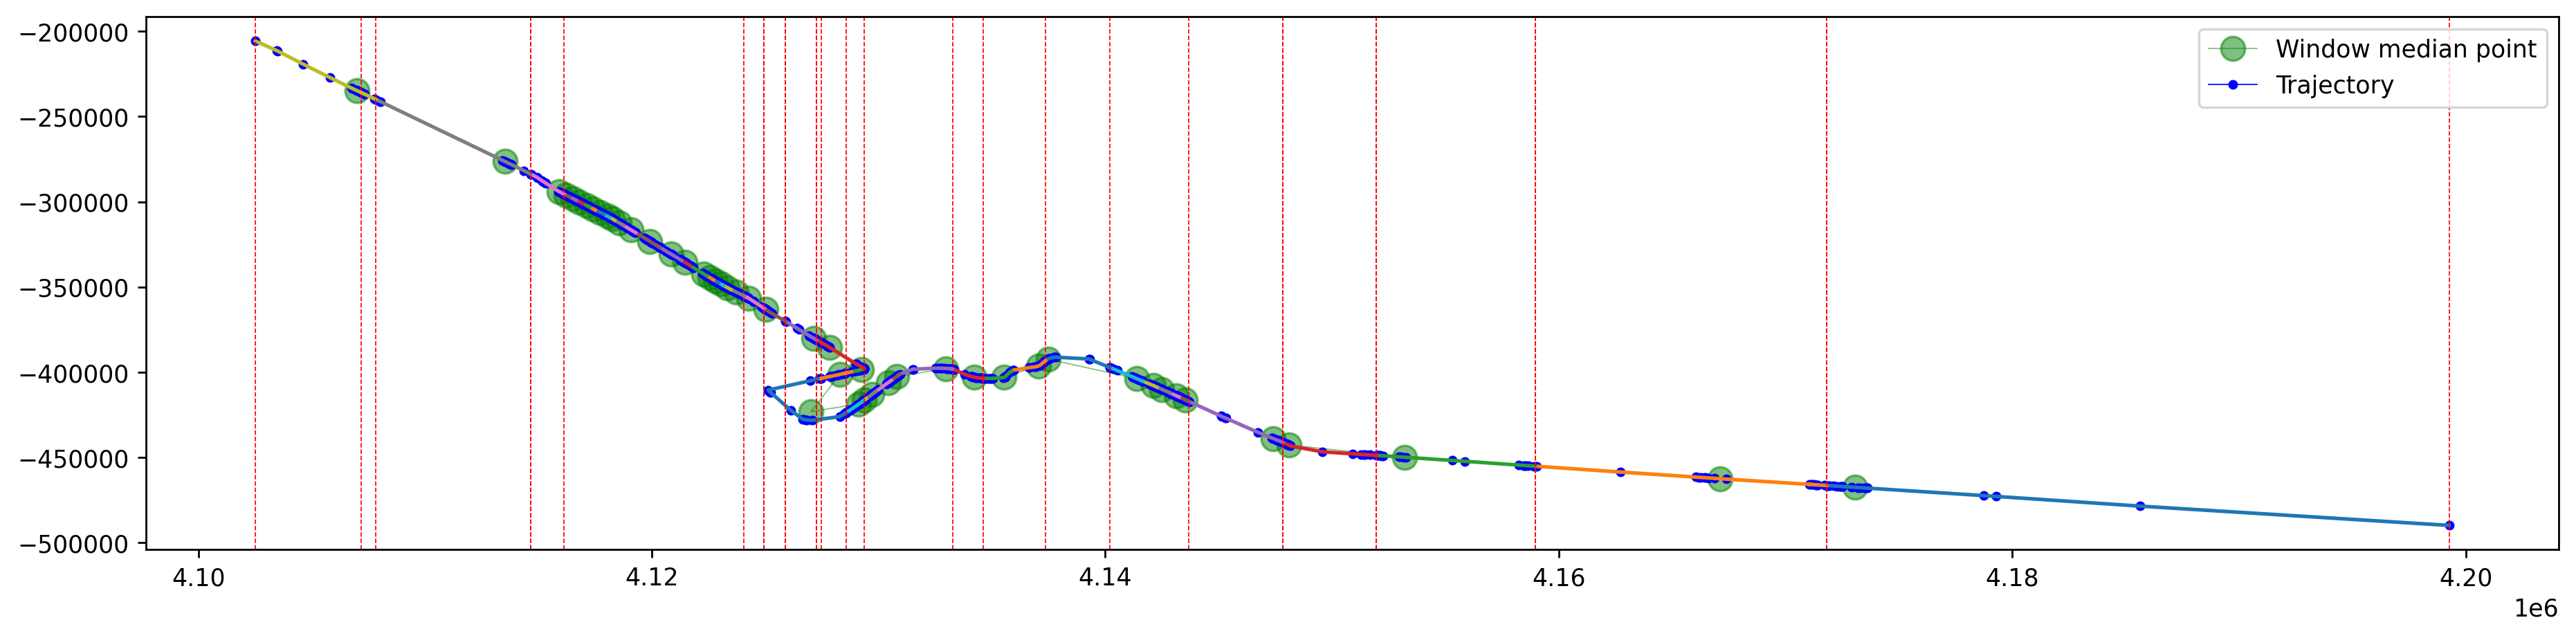

In [179]:
fig, ax = plt.subplots(figsize=(18, 4), dpi=250)

ax.plot(
    middles[:,0],
    middles[:,1],
    marker='o',
    ms=10,
    linestyle='-',
    color='g',
    linewidth=0.5,
    alpha=0.5,
    label='Window median point'
)

ax.plot(
    X[:,0],
    X[:,1],
    marker='o',
    ms=3,
    linestyle='-',
    color='b',
    linewidth=0.5,
    label='Trajectory'
)

for i, window in enumerate(windows):
    ax.plot(
        window[:, 0],
        window[:, 1],
        #label=f"Window {i+1}"
    )  # Plot each window

    # colour = "blue" if outlier_labels[i] == 1 else "red"
    # label = "Inlier" if outlier_labels[i] == 1 else "Outlier"

    if outlier_labels[i] == -1:
        # Add vertical lines at the start and end of outlier windows
        ax.axvline(x=window[0, 0], color="r", linestyle='--', linewidth=0.5)
        ax.axvline(x=window[-1, 0], color="r", linestyle='--', linewidth=0.5)

# Add a colorbar for the legend
plt.legend()

In [208]:
def animate_windows(trajectory: np.ndarray, window_size: int, interval: int = 500) -> None:
    """
    Create a simple animation showing how points are processed in windows.

    Args:
        trajectory: Input trajectory points (N x 2) or (N x 3)
        window_size: Size of sliding windows
        interval: Time between frames in milliseconds
    """
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the full trajectory in faded gray
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'gray', alpha=0.3,
            label='Full Trajectory')

    # Calculate number of windows
    n_points = len(trajectory)
    n_windows = n_points - window_size + 1

    def update(frame: int) -> Tuple:
        """Update function for animation."""
        # Clear previous window points
        for collection in ax.collections:
            collection.remove()

        # Get current window
        start_idx = frame
        end_idx = start_idx + window_size
        window = trajectory[start_idx:end_idx]

        # Plot window points
        # Source point (first point in window)
        source = ax.scatter(window[0, 0], window[0, 1], color='red',
                          marker='s', s=100, label='Source')

        # Middle points
        middle_points = ax.scatter(window[1:-1, 0], window[1:-1, 1],
                                 color='blue', s=50, label='Window Points')

        # Destination point (last point in window)
        dest = ax.scatter(window[-1, 0], window[-1, 1], color='green',
                         marker='^', s=100, label='Destination')

        # Update title to show progress
        ax.set_title(f'Processing Window {frame+1}/{n_windows}')

        # Add legend only on first frame
        if frame == 0:
            ax.legend()

        return source, middle_points, dest

    # Create animation
    anim = FuncAnimation(
        fig,
        update,
        frames=n_windows,
        interval=interval,
        blit=True
    )

    plt.show()
    return anim

In [231]:
windows[0][0,1]

-489817.20626798674

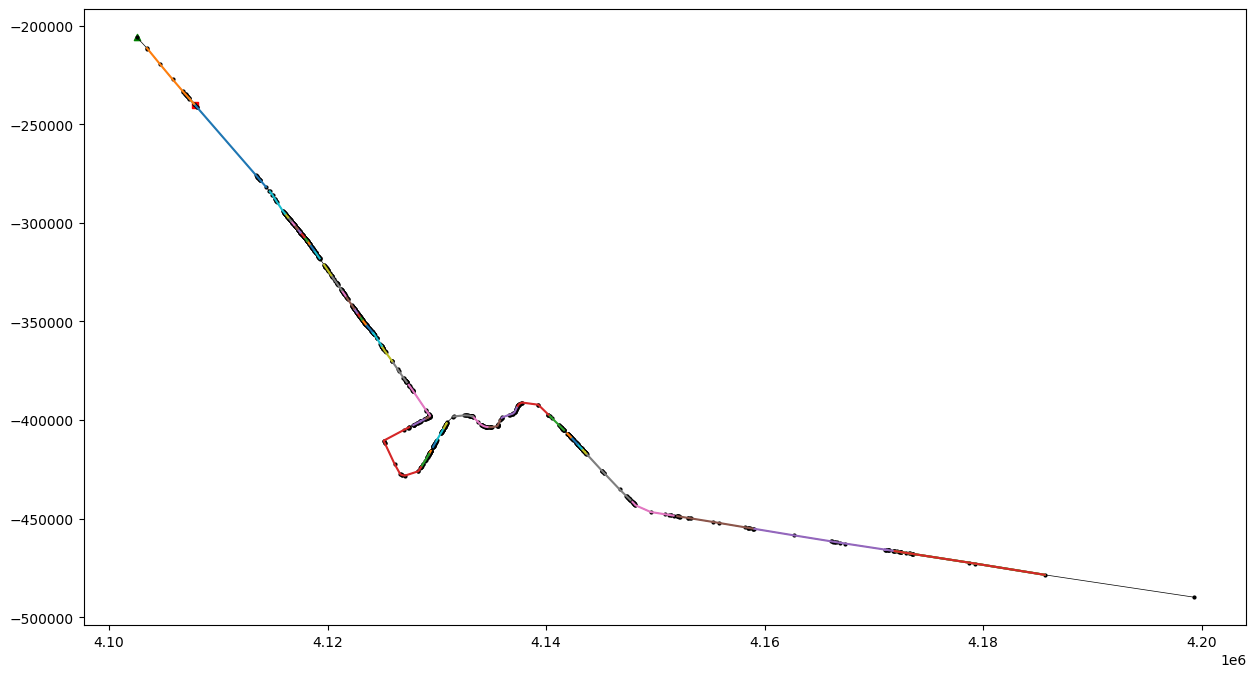

In [246]:
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes


def create_animation_frame(frame: int, windows: NDArray[float64], ax: Axes):
    """"""
    ax.clear()
    for collection in ax.collections:
        collection.remove()

    window = windows[frame]
    window_x, window_y = window[:,0], window[:,1]

    window_plot = ax.plot(window_x[1:-1], window_y[1:-1])
    source_plot = ax.scatter(window_x[0], window_y[0], color='red', marker='s', s=20, label='Source')
    destination_plot = ax.scatter(window_x[-1], window_y[-1], color='green', marker='^', s=20, label='Destination')

    return source_plot, destination_plot

fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

ax.plot(
    X[:,0],
    X[:,1],
    marker='o',
    ms=2,
    linestyle='-',
    color='black',
    linewidth=0.5,
    label='Full Trajectory'
)

animation = FuncAnimation(
    fig,
    create_animation_frame,
    frames=len(windows),
    fargs=(windows, ax),
    blit=True,
    interval=1500
)

HTML(animation.to_jshtml())

In [247]:
plt.close("all")

In [181]:
features[0]

array([4.25947333e+04, 4.25947333e+04, 4.25947333e+04, 4.25947333e+04,
       4.25947333e+04, 4.25947333e+04, 4.25947333e+04, 4.25947333e+04,
       4.25947333e+04, 2.96742065e+03, 1.00000000e+01, 9.00000000e+00])

In [182]:
outlier_scores

array([10.45555221,  2.17669904,  2.50868695,  1.56495874,  3.45830206,
        0.93683161,  0.93817379,  1.06254133,  1.01392706,  1.28425609,
        1.79662745,  1.26428771,  0.96730738,  1.84705755,  1.12723179,
        1.0089709 ,  1.09088054,  0.95794872,  0.95674227,  1.29437665,
        3.26847761,  1.02723955,  1.06793875,  2.099925  ,  1.55271537,
        2.50254322,  2.15843457,  0.94881725,  1.04853204,  1.0578229 ,
        1.04111451,  1.00098268,  1.01412958,  0.98960007,  1.09066028,
        0.9930598 ,  1.001895  ,  1.01552129,  1.11188115,  0.9554997 ,
        0.94205726,  1.00308756,  1.23417439,  1.17653538,  1.06195818,
        1.24462736,  1.90723836,  3.67113258,  2.81948082])

In [183]:
outlier_labels, sum(outlier_labels == -1)

(array([-1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
         1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1]),
 15)

In [113]:
len(windows)

49

## Improvements

1.   Parallelizing window processing since windows are independent
2.   Using vectorized operations for angle and distance calculations
3.   Pre-computing commonly used values like distances to middle point


*   Add Overlapping Windows with stride parameter?
*   Analyze at multiple window sizes?
*   Smooth features across adjacent windows?
*   Compute confidence based on consistent detection across overlaps?





In [152]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Wedge
import matplotlib.colors as mcolors
from typing import List, Tuple, Dict

class MiPoAnimator:
    def __init__(self, trajectory: np.ndarray, window_size: int, k: int):
        """
        Initialize the MiPo animation visualization.

        Args:
            trajectory: Input trajectory points (N x 2) or (N x 3)
            window_size: Size of sliding windows
            k: Number of angle bins
        """
        self.trajectory = trajectory
        self.window_size = window_size
        self.k = k

        # Calculate total number of windows
        self.n_points = len(trajectory)
        self.n_windows = self.n_points - window_size + 1

        # Setup the figure and axes
        self.fig = plt.figure(figsize=(15, 8))
        gs = self.fig.add_gridspec(2, 2, height_ratios=[2, 1])

        # Main trajectory plot
        self.ax_traj = self.fig.add_subplot(gs[0, :])
        self.ax_traj.set_title('Trajectory Processing')

        # Angle distribution plot
        self.ax_angles = self.fig.add_subplot(gs[1, 0], projection='polar')
        self.ax_angles.set_title('Angle Distribution')

        # Point count plot
        self.ax_points = self.fig.add_subplot(gs[1, 1])
        self.ax_points.set_title('Points Left/Right of Line')

        # Setup color scheme
        self.colors = list(mcolors.TABLEAU_COLORS.values())

        # Initialize plots
        self._setup_plots()

    def _setup_plots(self):
        """Initialize the static elements of all plots."""
        # Plot full trajectory (faded)
        self.ax_traj.plot(self.trajectory[:, 0], self.trajectory[:, 1],
                         'k-', alpha=0.3, label='Full Trajectory')

        # Setup angle bins
        self.ax_angles.set_theta_direction(-1)
        self.ax_angles.set_theta_zero_location('N')

        # Setup point count plot
        self.ax_points.set_xlim(-1, 2)
        self.ax_points.set_ylim(0, self.window_size)
        self.ax_points.set_xticks([0, 1])
        self.ax_points.set_xticklabels(['Left', 'Right'])

        plt.tight_layout()

    def animate(self, frame: int) -> Tuple:
        """
        Animation function called for each frame.

        Args:
            frame: Current frame number (window index)
        Returns:
            Tuple of artists to update
        """
        # Clear previous frame
        # Replace .clear() with explicit removal of collections
        while self.ax_traj.collections:
            self.ax_traj.collections[0].remove()
        while self.ax_angles.collections:
            self.ax_angles.collections[0].remove()
        while self.ax_points.collections:
            self.ax_points.collections[0].remove()

        # Get current window
        start_idx = frame
        end_idx = start_idx + self.window_size
        window = self.trajectory[start_idx:end_idx]

        # Calculate reference points
        source = window[0]
        destination = window[-1]
        middle = (source + destination) / 2

        # Plot current window
        color = self.colors[frame % len(self.colors)]

        # Plot window points
        self.ax_traj.scatter(window[:, 0], window[:, 1],
                           color=color, s=100, zorder=3)

        # Plot reference points
        self.ax_traj.scatter(source[0], source[1], color='red',
                           marker='s', s=150, label='Source', zorder=4)
        self.ax_traj.scatter(middle[0], middle[1], color='blue',
                           marker='o', s=150, label='Middle', zorder=4)
        self.ax_traj.scatter(destination[0], destination[1], color='green',
                           marker='^', s=150, label='Destination', zorder=4)

        # Plot reference line
        self.ax_traj.plot([source[0], destination[0]],
                         [source[1], destination[1]],
                         '--', color='gray', alpha=0.5)

        # Calculate angles and bin points
        angles = []
        left_points = []
        right_points = []

        for point in window[1:]:
            theta = self.calculate_angle(source, middle, point)
            angles.append(theta)

            # Classify points as left/right of line
            if theta < np.pi:
                left_points.append(point)
            else:
                right_points.append(point)

            # Plot point connection to middle
            self.ax_traj.plot([middle[0], point[0]],
                            [middle[1], point[1]],
                            '-', color=color, alpha=0.3)

        # Update angle distribution
        bins = np.histogram(angles, bins=self.k, range=(0, 2*np.pi))[0]
        bin_edges = np.linspace(0, 2*np.pi, self.k+1)
        width = 2*np.pi / self.k

        self.ax_angles.bar(bin_edges[:-1], bins, width=width,
                          alpha=0.5, color=color)

        # Update point counts
        self.ax_points.bar([0, 1],
                          [len(left_points), len(right_points)],
                          color=color, alpha=0.5)

        # Update titles with current window info
        self.ax_traj.set_title(f'Processing Window {frame+1}/{self.n_windows}')

        return self.ax_traj.collections + self.ax_angles.collections + self.ax_points.collections

    @staticmethod
    def calculate_angle(source: np.ndarray, middle: np.ndarray, point: np.ndarray) -> float:
        """Calculate angle between source-middle-point."""
        vector_ms = source - middle
        vector_mp = point - middle

        # Calculate magnitudes
        magnitude_ms = np.linalg.norm(vector_ms)
        magnitude_mp = np.linalg.norm(vector_mp)

        # Handle edge cases
        if magnitude_ms == 0 or magnitude_mp == 0:
            return 0.0

        # Calculate dot product and check for NaN
        dot_product = np.dot(vector_ms, vector_mp)
        if np.isnan(dot_product):
            return 0.0

        # Calculate norm product and check for NaN
        norms = magnitude_ms * magnitude_mp
        if np.isnan(norms) or norms == 0:
            return 0.0

        # Handle numerical precision issues
        cos_angle = np.clip(dot_product / norms, -1.0, 1.0)
        angle = np.arccos(cos_angle)

        # Determine which side using cross product
        if len(source) == 2:  # 2D case
            cross_product = vector_ms[0] * vector_mp[1] - vector_ms[1] * vector_mp[0]
        else:  # 3D case
            cross_product = np.cross(vector_ms, vector_mp)[1]

        if cross_product < 0:  # If point is on right side
            angle = 2 * np.pi - angle

        return angle

    def create_animation(self, interval: int = 500) -> FuncAnimation:
        """Create the animation with given frame interval."""
        anim = FuncAnimation(
            self.fig,
            self.animate,
            frames=self.n_windows,
            interval=interval,
            blit=True
        )
        return anim

In [160]:
from IPython.display import HTML

In [163]:
# # Create animator and animation
# animator = MiPoAnimator(X[:100], window_size=20, k=10)
# anim = animator.create_animation(interval=500)
# #anim.save('mipo_animation.gif', writer='pillow', fps=10)
# HTML(anim.to_jshtml())